# Naive Bayes base on Wamex Close Coords

In [34]:
import pickle
import pandas as pd

In [35]:
import os
os.getcwd()

'/Users/xiaohan/Documents/CriticalMinerals/xiao'

### Load Data

In [36]:
index_less_than_10km = pd.read_pickle('~/Documents/CriticalMinerals/eli/wamex_close_coords_to_shp_minedex_terminatedafter12hrs.pickle')

with open('../eli/wamex_close_coords_to_shp_minedex_terminatedafter12hrs.pickle', 'rb') as file:
    close_coords_indicies = pickle.load(file)

In [37]:
len(index_less_than_10km)

307574

In [38]:
close_coords_indicies = list(set(close_coords_indicies))
print(f"\n Sample: {close_coords_indicies[:10]} \n\n Length: {len(close_coords_indicies)}")


 Sample: [131072, 131073, 131084, 131085, 131086, 131087, 131088, 131089, 131090, 131091] 

 Length: 75628


In [39]:
wamex = pd.read_csv('~/Documents/CMProject/Data/WAMEX/WAMEX_1_Rockchip_Original.csv')
wamex.head(5)
wamex.shape

/Users/xiaohan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(402770, 143)

### Merge Index 

In [40]:
wamex = wamex.iloc[close_coords_indicies,:]
wamex.shape

(75628, 143)

In [41]:
wamex.columns

Index(['OBJECTID', 'DATASET', 'SAMPLEID', 'GSWANO', 'EXTRACT_DA', 'BATCH_NO',
       'QMAPID', 'DLAT', 'DLONG', 'EASTING',
       ...
       'W_ppm', 'WO3_ppm', 'Y_ppm', 'Y2O3_ppm', 'Yb_ppm', 'Yb2O3_ppm',
       'Zn_ppm', 'ZnO_ppm', 'Zr_ppm', 'ZrO2_ppm'],
      dtype='object', length=143)

### Nickel, Copper & Cobalt but in Bayes

In [42]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Copper', 'Nickel']
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni"
}

critical_mineral = full_to_atomic(critical_mineral)

TypeError: 'dict' object is not callable

In [43]:
new_cols = []
for col in wamex.columns: 
    if "ppm" in col:
        new_cols.append(col.split('_')[0])
    else:
        new_cols.append(col)

wamex.columns = new_cols

In [44]:

minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Cu', 'Ni', 'Co']

In [45]:

input_cols = ['DLAT', 'DLONG'] + minerals_atomic

In [46]:
df = wamex[input_cols]
df.head(5)

,DLAT,DLONG,Cu,Ni,Co
131072,-30.704511,121.551388,200.0,1347.0,65.0
131073,-30.707096,121.546128,160.0,642.0,47.0
131084,-31.768529,119.601723,172.0,19.0,-9999.0
131085,-31.768086,119.601774,117.0,26.0,-9999.0
131086,-31.764900,119.600154,52.0,10.0,-9999.0


## Data Cleaning

In [47]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
#     print(val)
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

df = df.applymap(replace_neg9999)
df = df.applymap(abs_halve_neg_val)

indexs_6666 = df[df.values == -6666].index
df = df.drop(index=indexs_6666)

indexs_0 = df[df.values == 0].index
df = df.drop(index=indexs_0)

In [48]:
df = df.reset_index(drop=True)
# df = df.drop(columns=['index'])
df.head()

,DLAT,DLONG,Cu,Ni,Co
0,15.352256,121.551388,200.0,1347.0000,65.0
1,15.353548,121.546128,160.0,642.0000,47.0
2,13.836055,120.647184,30.0,2300.0000,105.0
3,14.521251,119.909593,112.0,141.0000,63.0
4,13.832268,120.645988,65.0,1800.0001,75.0


## Modeling with Lat, Long, Cu, Ni to predict Co

In [53]:
y = df['Co']
X = df.drop(columns=['Co'])

In [56]:
#Splitting the dataset into training and testing variables
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
 
#keeping 80% as training data and 20% as testing data.

In [62]:
X_train.sample(5)

,DLAT,DLONG,Cu,Ni
5408,13.755588,120.964615,114.0,74.0
19925,14.606978,120.406872,5.0,5.0
17279,10.863137,120.492969,29.0,50.0
1116,14.870208,120.565337,15.0,15.0
11519,16.968010,119.108273,36.3,30.7


In [65]:
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
 
#Calling the Class
naive_bayes = MultinomialNB()
 
#Fitting the data to the classifier
naive_bayes.fit(X_train.astype(int) , y_train.astype(int))
 
#Predict on test data
train_preds = naive_bayes.predict(X_train)
test_preds = naive_bayes.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 26224976976785.184
Test MSE: 19403465088618.41


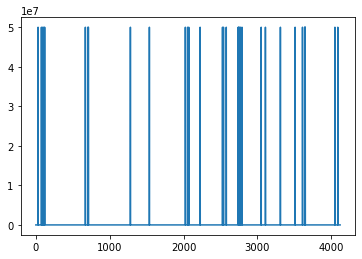

In [67]:
import matplotlib.pyplot as plt
plt.plot(range(0, len(test_preds)), y_test)

## Modeling when Lat and Long are removed